<!--
https://carpentries-incubator.github.io/geospatial-python/06-raster-intro.html
-->

# `rioxarray`

`rioxarray`:
-  is a Python extension for `xarray` to manipulate `xarray.DataArray`s as rasters. 
- means *raster input/output + xarray*. 

## Data
Raster filesfrom the US National Agriculture Imagery Program (NAIP)

- high-resolution aerial images from 2020 with four spectral bands: Red, Green, Blue and Near-infrared (NIR). 
- data is pre-processed into two rasters (RGB and NIR) 

## Import .tif

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rioxarray as rioxr

import geopandas as gpd
from shapely.geometry import Polygon

*There are multiple ways of opening a '.tif' file using `xarray` or `rioxarray`*

Use `rioxarray.open_rasterio()` function to open the '.tif' file:

In [2]:
# load NIR tif file
nir_fp = os.path.join(os.getcwd(),'data','naip','nir.tif')
nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

## `xr.DataArray` exploration

Let's verify the raster we loaded is an `xarray.DataArray`:

In [3]:
type(nir)

xarray.core.dataarray.DataArray

Access some attribues:

In [4]:
# print shape and data type
print('shape: ', nir.shape)
print('data type: ', nir.dtype, '\n')

shape:  (1, 3208, 2419)
data type:  uint8 



The `.values` attribute gives a view at the values at the corners:

In [5]:
# nir.values is a np.array: the underlying data
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[[167, 164, 161, ..., 147, 152, 151],
        [170, 170, 168, ..., 151, 149, 154],
        [176, 177, 177, ..., 151, 151, 151],
        ...,
        [ 94,  88, 101, ...,  83,  88,  79],
        [108,  95, 103, ...,  92,  91,  75],
        [ 94,  90, 104, ...,  87,  88,  82]]], dtype=uint8)

We can also plot our data:

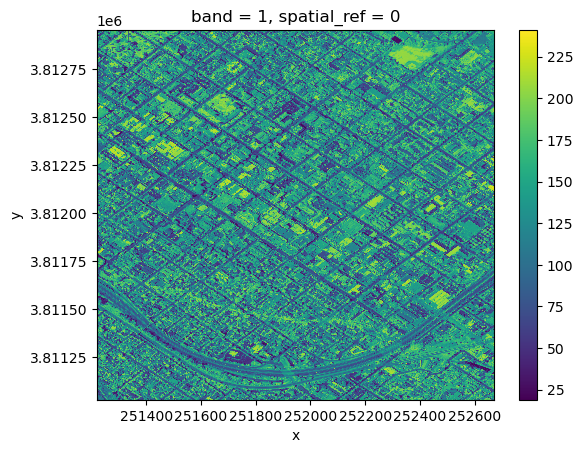

In [25]:
# exploratory plot
nir.plot()

*Can you guess where this?*

## `rio` accessor

An **accessor** in Python let's us access a different set of properties of an object.

Use the `.rio` accessor for `xarray.DataArray`s to access its raster properties. 

For example:

In [7]:
print('# bands: ', nir.rio.count)
print('height: ', nir.rio.height)
print('width: ', nir.rio.width, '\n')

print('spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('CRS: ', nir.rio.crs)

# bands:  1
height:  3208
width:  2419 

spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

affine transformation: 
| 0.60, 0.00, 251218.80|
| 0.00,-0.60, 3812952.00|
| 0.00, 0.00, 1.00| 

CRS:  EPSG:26911


*We have used accessors before, for example the `.str` and `.dt` accessors in `pandas`.*

## Multi-band raster

Import the RGB raster:

In [8]:
# open RGB raster
rgb_fp = os.path.join(os.getcwd(),'data','naip','rgb.tif')
rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

*Raster has three bands, instead of one. This makes sense because we know these bands correspond tothe Red, Green and Blue bands of the image.*

Check number of bands and shape:

In [9]:
print('rgb shape: ', rgb.shape)
print('rgb # bands: ', rgb.rio.count)

rgb shape:  (3, 3208, 2419)
rgb # bands:  3


In [10]:
# check geospatial data
print('shape: ', rgb.shape)
print('data type: ', rgb.dtype)
print('# bands: ', rgb.rio.count)
print('CRS: ', rgb.rio.crs)

# check if the CRSs of the rasters match
print( rgb.rio.crs == nir.rio.crs)

shape:  (3, 3208, 2419)
data type:  uint8
# bands:  3
CRS:  EPSG:26911
True


Plot raster

Since it has three bands, we can plot it as an image using the `.plot.imshow()` method, which will interpret the three bands of the object as RGB:

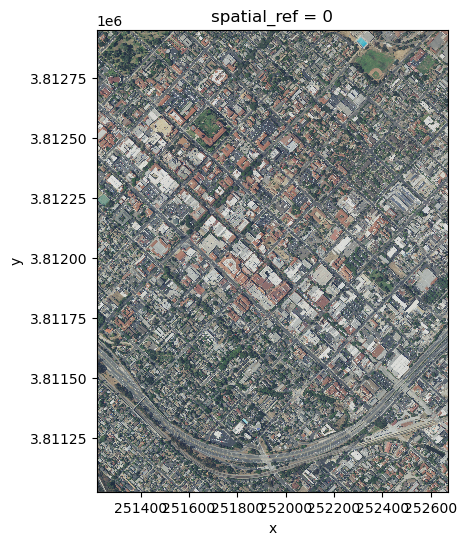

In [28]:
# parameters for plotting rasters
size = 6 # height in in of plot height
aspect = rgb.rio.width / rgb.rio.height # ratio of widht/height
# plot three bands as RGB image
rgb.plot.imshow(size=size, aspect=aspect)

## Box for clipping

Our area of interest (aoi) is a smaller region with a few blocks around the NCEAS building. 


*Go to https://geojson.io/ to get points*

In [12]:
# vertices of our aoi box
points = [[-119.70608227128903, 34.426300194372274],
          [-119.70608227128903, 34.42041139020533],
          [-119.6967885126002, 34.42041139020533],
          [-119.6967885126002, 34.426300194372274],
          [-119.70608227128903, 34.426300194372274]]

# create geodataframe with aoi 
aoi = gpd.GeoDataFrame(geometry=[Polygon(points)],
                           crs='epsg:4326')
aoi

,geometry
0,"POLYGON ((-119.70608 34.42630, -119.70608 34.4..."


*Let's break this down a bit:*

*- first, we use the `shapely`'s `Polygon()` function to create a polygon from our `points` list.*
*- in `[Polygon(points)]` we put this polygon inside a list so we can form the geometry column of our new `gpd.GeoDataFrame`*
*- we know all the geoJSON files have CRS equal to EPSG:4326/WGS 84, so we set the the CRS of our new `gpd.GeoDataFrame` to this.*

## Clip raster

Remember: **if two geospatial sets will interact they need to be in the same CRS**.  
Check CRSs:

In [13]:
# check CRss
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  epsg:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


In [14]:
# reproject aoi to rgb crs
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?',  aoi.crs == rgb.rio.crs)
aoi.crs

matched crs? True


<Bound CRS: PROJCS["NAD83 / UTM zone 11N",GEOGCS["NAD83",DATUM ...>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: Transformation from NAD83 to WGS84
- method: Position Vector transformation (geog2D domain)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich
Source CRS: NAD83 / UTM zone 11N

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

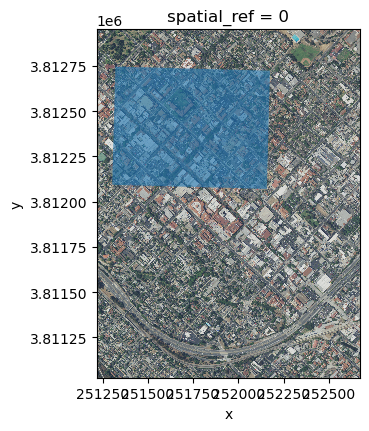

In [31]:
# plot aoi outline and RGB raster together
fig, ax = plt.subplots()
fig.set_size_inches((size, size*aspect)) # cannot use ax and size, aspect
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)

To clip the raster using the aoi polygon we use the `.rio.clip_box()` method:

In [16]:
# clip rasters to aoi
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
nir_small = nir.rio.clip_box(*aoi.total_bounds)

Notes:
- we had to use the `.rio` accessor to access the `clip_box()` method 
- similarly to the `shapely.box()` function, `.rio.clip_box()` usual parameters are minx, miny, maxx, maxy. We are using the `*` as an unpacking operator to get these from the list `aoi.total_bounds`.

Check clipped data:

original shape:  (3, 3208, 2419)
reduced shape:  (3, 1128, 1454)


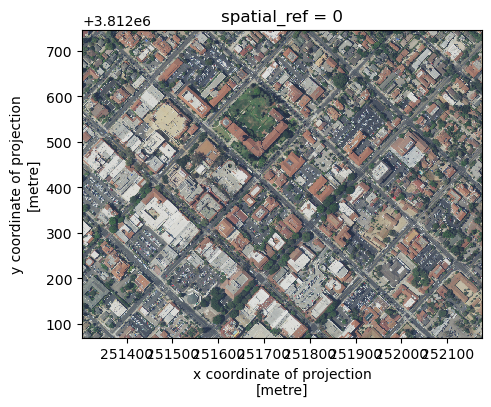

In [36]:
# check shape updates
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape)

# plot with correct sizes
size = 4
aspect = rgb_small.rio.width/ rgb_small.rio.height
rgb_small.plot.imshow(size=size, aspect=aspect)

original shape:  (1, 3208, 2419)
reduced shape:  (1, 1128, 1454)


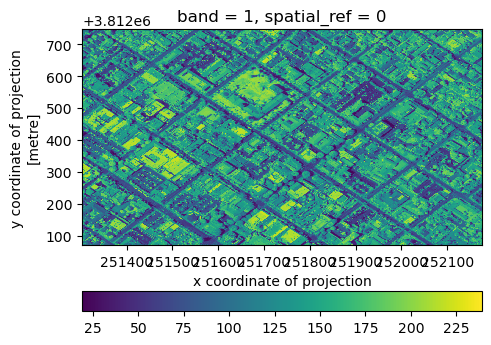

In [54]:
# chceck shape updates
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)


# changing the size and aspect does not account for the color bar
#nir_small.plot(size=size, aspect=aspect, cbar_kwargs={"location": "bottom"})
nir_small.plot()

In [ ]:

nir_small.plot(size=size, aspect=aspect)

## Compute NDVI

We want to compute the Normalized Difference Vegetation Index (NDVI) over our area of interest. 

NDVI: 
- index used to check if an area has live green vegetation.
- calculated using the NIR and red bands
- formula: $NDVI = \frac{NIR - Red}{NIR + Red}.$
- results range from -1 to 1
- plants: always positive values between 0.2 and 1

First, select the red band:

In [19]:
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1128, x: 1454)>
[1640112 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.513e+05 2.513e+05 ... 2.522e+05 2.522e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Update the type of our rasters (more on this later):

In [20]:
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype:', rgb_small.dtype, '.... converted dtype:', red16.dtype)
print('NIR: original dtype:', nir.dtype, '.... converted dtype:', nir16.dtype)

RED: original dtype: uint8 .... converted dtype: int16
NIR: original dtype: uint8 .... converted dtype: int16


Perform raster calculations using the same arithmetic we use for `np.array`s.

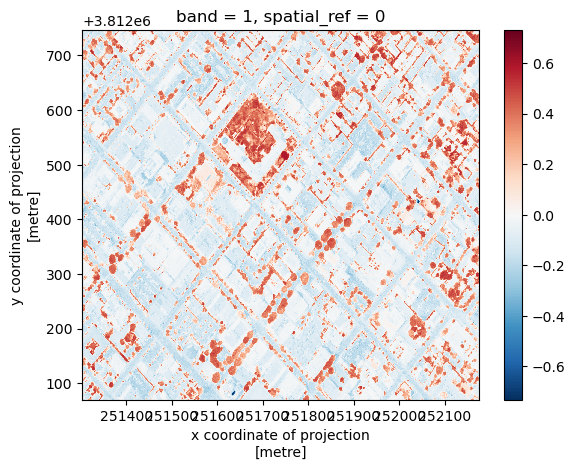

In [21]:
# calculate and plot NDVI
ndvi = (nir16 - red16)/(nir16+red16)
ndvi.plot()

*Remember that plants will always have positive NDVI values between 0.2 and 1. Can you spot the Courthouse?*


## Why change the data type?
`uint8` (8-bit unsigned integer) is a very small data type that only holds integers from 0 up to 255. 
Calculations with `uint8` don't  return what we are used to when working with integers:

In [22]:
np.uint8(150) + np.uint8(150)

/tmp/ipykernel_820682/1890984988.py:1: RuntimeWarning: overflow encountered in ubyte_scalars
  np.uint8(150) + np.uint8(150)


44

In the NDVI formula we have to add NIR + Red. 
If both NIR and Red are very close to 255, when we add them, the calculation overflows the `uint8` data type and we get garbage out of the calculation:

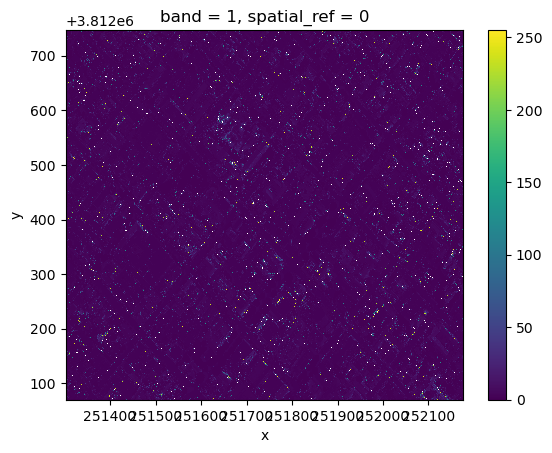

In [23]:
x = (nir - red)/(nir + red)
x.plot()

*This is why we need to manually convert both rasters into `int16`, which will be big enough to hold all the numbers that appear in the calculations.*

Notice too, that when we performed the ndvi calculation we did not get any warning, although we were overflowing the computation at every cell of our array. 
This is can be an example of *failing silently*, where we don't get any warnings about the errors in our computation. 

**So important to double-check our results!**
